In [ ]:
import os
import sys

os.chdir('..')


In [6]:
!pwd

/Users/alexc/Desktop/UofG/Lvl5-Project/test-suite-enhancement


# Helper scripts

In [35]:
import json

# Print out all the user prompts stored in task json
task_json_path = "data/batch_requests/batch_task_jsons/batch_tasks_100.jsonl"
with open(task_json_path, 'r') as f:
    task_jsonl = f.read()
tasks = task_jsonl.split('\n')
for task in tasks:
    if not task.strip():
        continue
    task_json = json.loads(task)
    prompts = task_json['body']['messages']
    user_prompt = next((msg['content'] for msg in prompts if msg['role'] == 'user'), None)
    print(user_prompt)


# CLASS UNDER TEST: HumanEval_99.py

def closest_integer(value):
    '''
    Create a function that takes a value (string) representing a number
    and returns the closest integer to it. If the number is equidistant
    from two integers, round it away from zero.

    Examples
    >>> closest_integer("10")
    10
    >>> closest_integer("15.3")
    15

    Note:
    Rounding away from zero means that if the given number is equidistant
    from two integers, the one you should return is the one that is the
    farthest from zero. For example closest_integer("14.5") should
    return 15 and closest_integer("-14.5") should return -15.
    '''

    from math import floor, ceil

    if value.count('.') == 1:
        # remove trailing zeros
        while (value[-1] == '0'):
            value = value[:-1]

    num = float(value)
    if value[-2:] == '.5':
        if num > 0:
            res = ceil(num)
        else:
            res = floor(num)
    elif len(value) > 0:
        res = int(rou

In [ ]:
# Add a identifier value to all the batches
BATCHES_JSON = 'data/batch_requests/batch_requests.jsonl'
def add_identifier(json_path, key, value):
    with open(json_path, 'r') as f:
        task_jsonl = f.read()
    tasks = task_jsonl.split('\n')
    for i, task in enumerate(tasks):
        if not task.strip():
            continue
        task_json = json.loads(task)
        task_json['identifiers'][key] = value
        tasks[i] = json.dumps(task_json)

    with open(json_path, 'w') as f:
        f.write('\n'.join(tasks))

# add_identifier(BATCHES_JSON, 'flag', 'old_1')


In [ ]:
from src.evaluation_entry import EvaluationEntry

def add_identifier_to_eval_entries():
    # Add an identifier to all the eval entries whose batch has the flag 'old_1'
    with open(BATCHES_JSON, 'r') as f:
        task_jsonl = f.read()
    tasks = task_jsonl.split('\n')
    for i, task in enumerate(tasks):
        if not task.strip():
            continue
        task_json = json.loads(task)
        if 'flag' in task_json['identifiers'] and task_json['identifiers']['flag'] == 'old_1':
            # Add the identifier to the eval entries
            print(task_json['batch_id'])
            eval_entry = EvaluationEntry.get_eval_entry(task_json['batch_id'], "human_eval")
            if not eval_entry:
                continue
            print(eval_entry.eval_id)
            eval_entry.identifiers["flag"] = 'old_1'
            # eval_entry.save()
    
# add_identifier_to_eval_entries()


In [85]:
from src.evaluation_entry import EvaluationEntry

# Update the enhanced metrics from string to json
def convert_enhanced_entry_metrics():
    eval_entries = EvaluationEntry.load_all("human_eval")
    for eval_entry in eval_entries:
        if type(eval_entry.eval_data["enhanced_project_evaluation"]) == str:
            try:
                eval_entry.eval_data["enhanced_project_evaluation"] = json.loads(eval_entry.eval_data["enhanced_project_evaluation"])
                eval_entry.eval_data["enhanced_test_evaluation"] = json.loads(eval_entry.eval_data["enhanced_test_evaluation"])
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON for eval entry {eval_entry.eval_id}: {e}")
                continue
            # eval_entry.save()
    
# convert_enhanced_entry_metrics()

In [33]:
# Remove tha task_path from all the new batches
BATCHES_JSON = 'data/batch_requests/batch_requests.jsonl'
def remove_task_path(json_path):
    with open(json_path, 'r') as f:
        task_jsonl = f.read()
    tasks = task_jsonl.split('\n')
    for i, task in enumerate(tasks):
        if not task.strip():
            continue
        
        task_json = json.loads(task)
        # print(task_json["batch_id"])
        identifiers = task_json['identifiers']
        if 'flag' in identifiers and identifiers['flag'] == 'old_1':
            continue
        
        task_json['task_json'] = None
        tasks[i] = json.dumps(task_json)

    with open(json_path, 'w') as f:
        f.write('\n'.join(tasks))

# remove_task_path(BATCHES_JSON)

# Evaluation

1. Create a chart/table for correctness metrics
2. Create a chart/table for coverage metrics
3. Create a chart/table for code quality metrics

In [45]:
# Transform the task_json to csv
import pandas as pd
from IPython.display import display

def create_initial_csv(project_name):

    # Create a list to store the data
    data = []

    for test_source in ["human_written", "chatgpt", "pynguin"]:
        # Read the test_source json file
        with open(f"data/{project_name}/tests/{test_source}/correctness_evaluation.json", 'r') as f:
            test_suite_correctness_data = json.load(f)
        # print(task_json)

        total_tests = test_suite_correctness_data["correctness_eval_counts"]["stats_post_removal"]["passed_tests"] + test_suite_correctness_data["correctness_eval_counts"]["stats_post_repair"]["failed_tests"]
        test_source_data = {
            "test_source": test_source,
            "total_classes" : test_suite_correctness_data["correctness_eval_counts"]["stats_pre_repair"]["total_classes"],
            "total_tests" : total_tests,

            # Correctness stats
            "passed_initially" : test_suite_correctness_data["correctness_eval_counts"]["stats_pre_repair"]["passed_tests"],
            "passed_after_repair" : test_suite_correctness_data["correctness_eval_counts"]["stats_post_removal"]["passed_tests"],
            "syntax_errors_initially" : test_suite_correctness_data["correctness_eval_counts"]["stats_pre_repair"]["syntax_errors"],
            "syntax_errors_after_repair" : test_suite_correctness_data["correctness_eval_counts"]["stats_post_removal"]["syntax_errors"],
            "compilation_errors_initially" : test_suite_correctness_data["correctness_eval_counts"]["stats_pre_repair"]["compilation_errors"],
            "compilation_errors_after_repair" : test_suite_correctness_data["correctness_eval_counts"]["stats_post_removal"]["compilation_errors"],
            "no_test_classes_after_repair" : test_suite_correctness_data["correctness_eval_counts"]["stats_post_removal"]["no_tests_classes"],
            
            # Repair stats
            "rule_1_repair_count": total_tests,
            "rule_2_repair_count": 0,
            "rule_2_repaired_tests": [],
            "rule_3_repair_count": len(test_suite_correctness_data["repair_stats"]["rule_2"]),
            "rule_3_repaired_tests": test_suite_correctness_data["repair_stats"]["rule_2"],
            "rule_4_repair_count": len(test_suite_correctness_data["repair_stats"]["rule_3"]),
            "rule_4_repaired_tests": test_suite_correctness_data["repair_stats"]["rule_3"],
            "rule_5_repair_count": len(test_suite_correctness_data["repair_stats"]["rule_5"]),
            "rule_5_repaired_tests": test_suite_correctness_data["repair_stats"]["rule_5"],
            "rule_6_repair_count": len(test_suite_correctness_data["repair_stats"]["rule_4"]),
            "rule_6_repaired_tests": test_suite_correctness_data["repair_stats"]["rule_4"],
            "rule_7_repair_count": len(test_suite_correctness_data["repair_stats"]["rule_0"]),
            "rule_7_repaired_tests": test_suite_correctness_data["repair_stats"]["rule_0"],
            "rule_8_repair_count": len(test_suite_correctness_data["repair_stats"]["rule_1"]),
            "rule_8_repaired_tests": test_suite_correctness_data["repair_stats"]["rule_1"],
        }
        data.append(test_source_data)
    
    
    # Create a DataFrame from the data
    df = pd.DataFrame(data)
    display(df)
    return df

    # # Save the DataFrame to a CSV file
    # df.to_csv('data/batch_requests/batch_requests.csv', index=False)

df = create_initial_csv('human_eval')


,test_source,total_classes,total_tests,passed_initially,passed_after_repair,syntax_errors_initially,syntax_errors_after_repair,compilation_errors_initially,compilation_errors_after_repair,no_test_classes_after_repair,...,rule_4_repair_count,rule_4_repaired_tests,rule_5_repair_count,rule_5_repaired_tests,rule_6_repair_count,rule_6_repaired_tests,rule_7_repair_count,rule_7_repaired_tests,rule_8_repair_count,rule_8_repaired_tests
0,human_written,164,1181,1172,1172,0,0,0,0,4,...,4,"[test_HumanEval_50.py, test_HumanEval_10.py, t...",0,[],0,[],0,[],0,[]
1,chatgpt,164,1170,0,969,0,0,1,0,4,...,164,"[test_HumanEval_99.py, test_HumanEval_129.py, ...",1,[test_HumanEval_20.py],0,[],51,"[test_HumanEval_139.py, test_HumanEval_158.py,...",0,[]
2,pynguin,121,147,143,143,0,0,0,0,1,...,0,[],0,[],0,[],0,[],0,[]


## Correctness evaluation

In [ ]:
def create_correctness_table(df):
    # Define relevant columns
    correctness_cols = [
        'total_tests',
        'passed_initially',
        'passed_after_repair',
        'syntax_errors_initially',
        'syntax_errors_after_repair',
        'compilation_errors_initially',
        'compilation_errors_after_repair',
        'no_test_classes_after_repair'
    ]

    # Melt and pivot the nominal values
    melted = df.melt(
        id_vars=['test_source'],
        value_vars=correctness_cols,
        var_name='metric',
        value_name='value'
    )
    correctness_table = melted.pivot(index='metric', columns='test_source', values='value').fillna(0).astype(int)

    # Create percentage table
    percentage_table = correctness_table.copy().astype(float)

    for col in percentage_table.columns:
        total = percentage_table.loc['total_tests', col]
        for idx in percentage_table.index:
            if idx != 'total_tests':
                percentage_table.loc[idx, col] = (percentage_table.loc[idx, col] / total * 100) if total > 0 else 0.0
            else:
                percentage_table.loc[idx, col] = None  # No % for total_classes

    # Format percentages
    percentage_table = percentage_table.applymap(
        lambda x: f"{x:.2f}%" if pd.notna(x) else ""
    )

    # Format nominal values
    correctness_table = correctness_table.astype(str)

    # Add suffix to percentage metric names
    percentage_table.index = [f"{i} (%)" if i != 'total_tests' else '' for i in correctness_table.index]

    # Combine both tables
    combined_table = pd.concat([correctness_table, percentage_table])

    # Drop empty index rows (from total_classes in %)
    combined_table = combined_table[combined_table.index != '']

    # Optional: sort rows to group nominal & percentage values together
    combined_table = combined_table.sort_index()

    # Display
    print(combined_table)


create_correctness_table(df)

test_source                          chatgpt human_written  pynguin
compilation_errors_after_repair            0             0        0
compilation_errors_after_repair (%)    0.00%         0.00%    0.00%
compilation_errors_initially               1             0        0
compilation_errors_initially (%)       0.61%         0.00%    0.00%
no_test_classes_after_repair               4             4        1
no_test_classes_after_repair (%)       2.44%         2.44%    0.83%
passed_after_repair                      969          1172      143
passed_after_repair (%)              590.85%       714.63%  118.18%
passed_initially                           0          1172      143
passed_initially (%)                   0.00%       714.63%  118.18%
syntax_errors_after_repair                 0             0        0
syntax_errors_after_repair (%)         0.00%         0.00%    0.00%
syntax_errors_initially                    0             0        0
syntax_errors_initially (%)            0.00%    

/var/folders/z7/grqfp40j73xcvr_rkz8n20hm0000gn/T/ipykernel_37277/373456928.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  percentage_table = percentage_table.applymap(


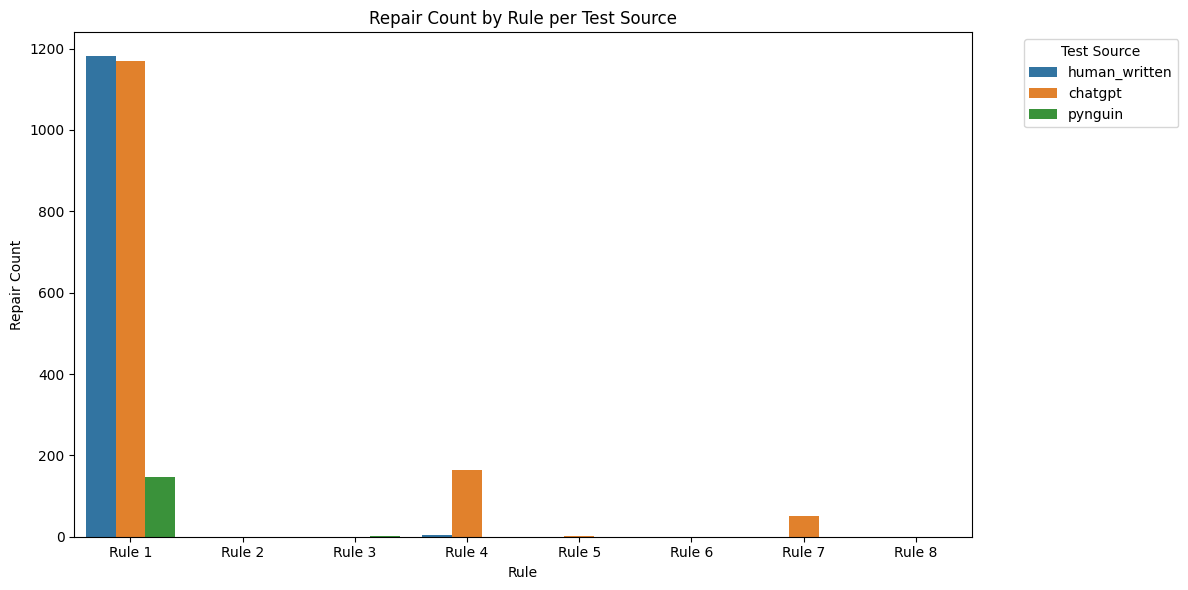

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_rule_repair_figure(df:pd.DataFrame):
    # Extract only the repair count columns
    repair_cols = [col for col in df.columns if col.endswith('_repair_count') and col.startswith('rule_')]

    # Melt the DataFrame to long format for plotting
    melted_df = df.melt(
        id_vars=['test_source'],
        value_vars=repair_cols,
        var_name='rule',
        value_name='repair_count'
    )

    # Optional: Clean rule names for plotting
    melted_df['rule'] = melted_df['rule'].str.replace('_repair_count', '').str.replace('rule_', 'Rule ')

    # Plot it!
    plt.figure(figsize=(12, 6))
    sns.barplot(data=melted_df, x='rule', y='repair_count', hue='test_source')

    plt.title('Repair Count by Rule per Test Source')
    plt.xlabel('Rule')
    plt.ylabel('Repair Count')
    plt.legend(title='Test Source', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

create_rule_repair_figure(df)

In [49]:
def create_rule_repair_table(df):
    # Extract only the repair count columns
    repair_cols = [col for col in df.columns if col.endswith('_repair_count') and col.startswith('rule_')]

    # Melt the DataFrame to long format for plotting
    melted_df = df.melt(
        id_vars=['test_source'],
        value_vars=repair_cols,
        var_name='rule',
        value_name='repair_count'
    )

    # Pivot the melted dataframe to display rules as rows and test_sources as columns
    table_df = melted_df.pivot(index='rule', columns='test_source', values='repair_count')

    # Optional: fill NaNs with 0s (in case some sources are missing a rule)
    table_df = table_df.fillna(0).astype(int)

    # Display the table
    print(table_df)

create_rule_repair_table(df)

test_source          chatgpt  human_written  pynguin
rule                                                
rule_1_repair_count     1170           1181      147
rule_2_repair_count        0              0        0
rule_3_repair_count        0              0        2
rule_4_repair_count      164              4        0
rule_5_repair_count        1              0        0
rule_6_repair_count        0              0        0
rule_7_repair_count       51              0        0
rule_8_repair_count        0              0        0


## Correctness evaluation

In [ ]:
# Correctness metrics

def get_initial_coverage_metrics(test_source):
    # Read the CSV file into a DataFrame

    df = pd.read_csv('data/coverage_metrics/test_source.csv')

    # Display the first few rows of the DataFrame
    print(df.head())

    # Display the summary statistics of the DataFrame
    print(df.describe())